In [2]:

from torch.utils.data import DataLoader
from generators.subseries_converter import EchoStateDataset
from models.vanila_mlm_transformer import TransformerMLMModel
from generators.brownian_motion_generator import BrownianMotionDataset
from generators.poisson_process_generator import PoissonProcessDataset
from models.vanilla_transformer import TransformerModel
from probes.linear_probe import LinearProbe
import matplotlib.pyplot as plt


checkpoint_path = "/home/wojciech/private/magisterka/TFTS/transformer-every-n-epoch-epoch=001399.ckpt"

# Load the trained model
model = TransformerMLMModel.load_from_checkpoint(checkpoint_path)
model.to('cuda')

n_input = 1
n_reservoir = 10
spectral_radius = 0.99
sparsity = 0.1
input_scaling = 0.1
leak_rate = 0.7
device = 'cuda'
train_len = 1000
val_len = 10
lr = 1e-4

ESN_id = 40

# Create dataset and dataloaders
batch_size = 1
series_length = 100
tile_size = 1
stride = 1
padding = 0

val_dataset = EchoStateDataset(
        num_series=val_len,
        series_length=series_length,
        tile_size=tile_size,
        stride=stride,
        padding=padding,
        n_input=n_input,
        n_reservoir=n_reservoir,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        input_scaling=input_scaling,
        leak_rate=leak_rate,
        device=device,
        esn_id=ESN_id,
        initial_seed=0,
        non_repeat = False
    )

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

/home/wojciech/anaconda3/envs/TFTS/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.4.0
/home/wojciech/anaconda3/envs/TFTS/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
x, y = next(iter(val_loader))

In [4]:
predictions = []
for i in range(x.shape[1]):
    new_x = x.detach().clone()
    new_x[:, i, :] = 0
    new_x = new_x.to('cuda')
    x_dash = model(new_x)
    predictions.append(x_dash[:, i, :])

In [5]:
import torch
predictions = torch.stack(predictions, dim=1)

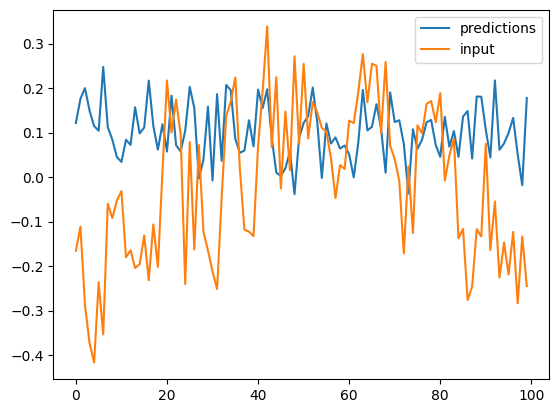

In [6]:
plt.plot(predictions.detach().cpu().numpy().flatten(), label='predictions')
plt.plot(x.detach().cpu().numpy().flatten(), label='input')
plt.legend()

In [25]:
from sklearn.metrics import r2_score

r2_score(predictions.cpu().detach().numpy().flatten(), x.cpu().detach().numpy().flatten())

-72.31412506103516

(array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 3., 0., 2.,
        4., 0., 2., 2., 3., 2., 1., 2., 0., 3., 0., 1., 2., 1., 1., 0., 2.,
        1., 3., 1., 1., 1., 3., 0., 2., 0., 2., 2., 5., 4., 3., 0., 0., 1.,
        1., 0., 4., 2., 2., 0., 3., 1., 0., 1., 2., 2., 1., 4., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([-6.00722849e-01, -5.91616452e-01, -5.82510054e-01, -5.73403656e-01,
        -5.64297259e-01, -5.55190861e-01, -5.46084464e-01, -5.36978066e-01,
        -5.27871609e-01, -5.18765211e-01, -5.09658813e-01, -5.00552416e-01,
        -4.91446018e-01, -4.82339621e-01, -4.73233223e-01, -4.64126825e-01,
        -4.55020428e-01, -4.45914030e-01, -4.36807632e-01, -4.27701235e-01,
        -4.18594807e-01, -4.09488410e-01, -4.00382012e-01, -3.91275615e-01,
        -3.82169217e-01, -3.73062819e-01, -3.63956422e-01, -3.54849994e-01,
        -3.4574359

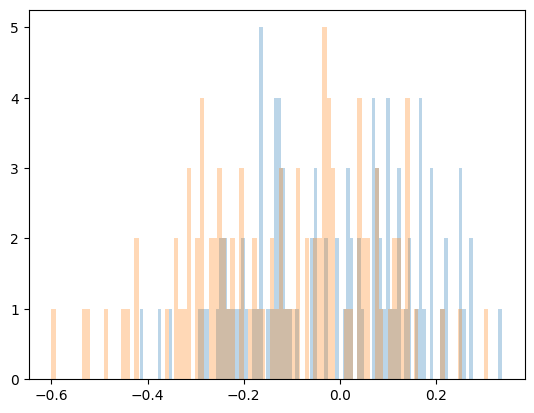

In [7]:
plt.hist(x.detach().cpu().numpy().flatten(), alpha=0.3, bins=100)
plt.hist((x-predictions.cpu()).detach().numpy().flatten(), alpha=0.3, bins=100)